In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import scipy.ndimage as ndimage
import scipy.signal as signal
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import itertools
import random

In [3]:
import fileio
import fit

In [4]:
reload(fileio);reload(fit)
song = fit.quantized_song(fileio.get_one_song())



In [5]:
def histories(song,
        quantum=0.25,
        n_pitchclasses=12,
        idx=57, #arbitrary
        horizon=32,
        #offset=3,
        ):
    """Return the del-t, del-p, n tuples
    (0,0,n) is the result
    every result has `n_pitchclasses` different interpretations,
    for each of `n_pitchclasses` different orders in this step.
    We want to keep the relative addresses the same,
    so we re-interpret by masking some of the current row.
    """
    all_steps = song.index.get_level_values(0)
    mask = (all_steps<=idx) & (all_steps>=(idx-horizon))
    mysteps = song.iloc[mask,:]
    # for idx, step_count in mysteps.iterrows():
#     now = int(idx[0])
#     now_t = step.time
#     here = int(idx[1])
#     hist = song[(song.time>=(now_t-horizon))&(song.time<=(now_t))]
#     hist["p"] = np.mod(hist.index.get_level_values(1), n_halfsteps)
#     hist["age"] = now_t - hist["time"]
#     del(hist["time"])
#     print idx, (here, now, now_t)
#     print step
#     print hist
    return mysteps
my=histories(song)

In [22]:
influence_arr = None
obs = None
hidden_sigs = None

def co_occurrences(song, n_pitchclasses=12):
    """
    My hypothesis is that there is a single kernel shape,
    and it is combined in 12 unobserved ratios.
    This leaves 12 unknowns for each observation.
    We can constrain the kernel by making it symmetrical, or mean 0 etc.
    But how to constrain the observations? Sparsity? Why not? Why not fucking sparsity?
    This is a simple optimization; cheap enough to do with non-SGD methods.
    Could be done spectrally; let's go for basic for now.
    Could do either log-rate, or linear-rate constrained non-neg.
    Cross validation? How? The background is still unobserved.
    We also wish to give them... per-step free mean rate? Per piece?
    """
    global influence_arr, penalty, obs, hidden_sigs
    penalty = 0.0
    influence_arr = np.zeros(n_pitchclasses)
    # signal.convolve2d version
    #influence_arr[n_pitchclasses/2-1] = 1
    # ndimage.filters.convolve version, slightly faster
    influence_arr[n_pitchclasses/2] = 1
    #Don't forget the offset. Global? Per step?
    obs = song.n.values.reshape(-1, n_pitchclasses)
    #trim null and singleton steps (destroys time info. Is that OK?)
    obs = obs[obs.sum(1)>1,:]
    hidden_sigs = np.copy(obs)
    predicted_rates = ndimage.filters.convolve(hidden_sigs, influence_arr.reshape(1,-1), mode="wrap")
    return None

co_occurrences(song) 

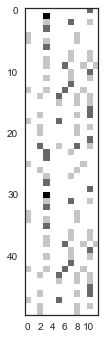

In [23]:
with sns.axes_style("white"):
    plt.imshow(ndimage.filters.convolve(obs, influence_arr.reshape(1,-1), mode="wrap")[:50,:], interpolation='nearest')

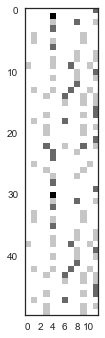

In [24]:
with sns.axes_style("white"):
    plt.imshow(signal.convolve2d(obs, influence_arr.reshape(1,-1), mode="same", boundary="wrap")[:50,:], interpolation='nearest')

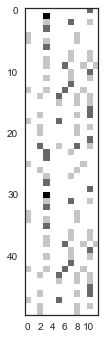

In [25]:
with sns.axes_style("white"):
    plt.imshow(obs[:50,:], interpolation='nearest')

In [21]:
%%timeit
signal.convolve2d(obs, influence_arr.reshape(1,-1), mode="same", boundary="wrap")

1000 loops, best of 3: 384 µs per loop


In [20]:
%%timeit
ndimage.filters.convolve(obs, influence_arr.reshape(1,-1), mode="wrap")

10000 loops, best of 3: 75.3 µs per loop


In [26]:
np.copy?